In [41]:
import yaml
import numpy as np
from tools import plot_surface
import matplotlib.pyplot as plt
from Bragg_mirror_sf import *
from make_beam import make_gaus_beam
from scipy.stats import skewnorm

In [42]:
with open('../input/input.yaml') as f:
    dict = yaml.load(f, Loader=yaml.FullLoader)
    print(dict)

{'crystal': {'theta': 45, 'd': 0.0002}, 'beam': {'dgrid': 0.0001, 'ncar': 100, 'nslice': 50, 'w0': 4e-05, 'Eph': 9831.88, 'npadx': 1000}, 'diode': {'response_curve': {'type': 'function', 'skew_num': 10.0, 'noise_level': 0.05, 't_decay': 1e-08, 'n_sample': 1000}, 'position': {'d': 1.0, 'x': 0.0, 'y': 0.0, 'radius': 8e-05}}}


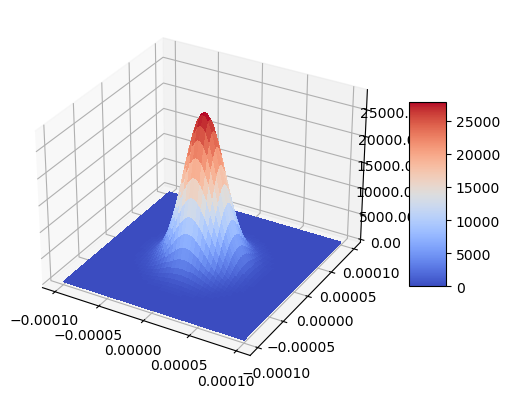

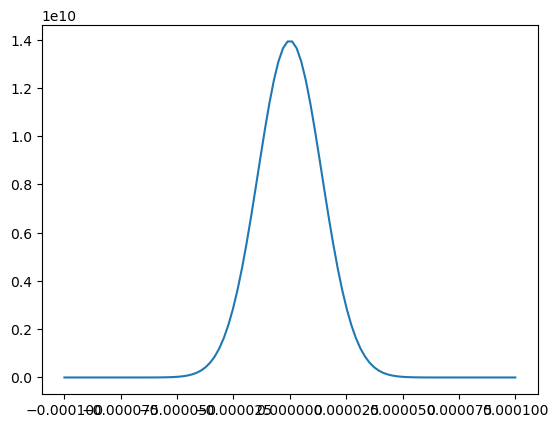

In [9]:
ncar = 100
dgrid =100e-6
npadx = 1000
w0 = 40e-6
xlamds = 1.26e-10
sigma = w0/2
k = 2*np.pi/xlamds

x = np.linspace(-dgrid, dgrid,  ncar)
y = np.linspace(-dgrid, dgrid,  ncar)
dx = np.mean(np.diff(x))
dy = np.mean(np.diff(y))
xmesh, ymesh = np.meshgrid(x, y, indexing = 'ij')


field = 1. / (2. * np.pi * sigma**2) * np.exp(-((xmesh)**2. / (2. * sigma**2.) + (ymesh)**2. / (2. * sigma**2.)))
field /= np.sqrt(np.sum(np.abs(field)**2)*dx*dy)
plot_surface(x, y , field)
plt.plot(x, np.sum(np.abs(field)**2, axis = 1) )


In [10]:
np.sum(np.abs(field)**2)*dx*dy

1.0

In [44]:
Eph = 9831.88
xlamds = 1.23984198/Eph*1e-6

In [45]:
xlamds

1.261042628673255e-10

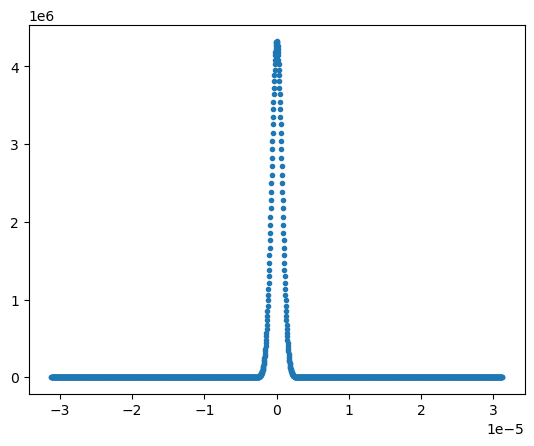

In [46]:

Dkx = 2*np.pi/dx
Dky = 2*np.pi/dy
nx_padded = ncar + 2*npadx
kx = Dkx/ 2. * np.linspace(-1.,1.,nx_padded)
ky = Dkx/ 2. * np.linspace(-1.,1.,ncar)
kx_mesh, ky_mesh = np.meshgrid(kx, ky, indexing = 'ij')
xs = (np.arange(nx_padded) - np.floor(nx_padded/2))*dx
field = np.pad(field, ((npadx, npadx), (0,0)))
fftfld = np.fft.fftshift(np.fft.fft2(field), axes=(0,1))
plt.plot(kx/k, np.sum(np.abs(fftfld)**2, axis = 1), '.')

In [47]:
theta0 = np.pi/4 + 10e-6
theta = kx/k + theta0
R0H, R00 = get_Bragg_mirror_response_theta(theta = theta, eph_0=9831.88, d=200e-6)


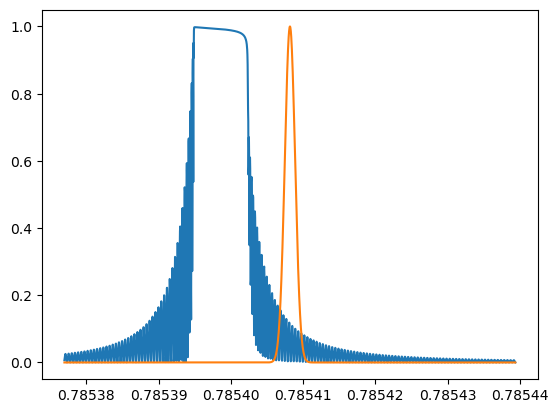

In [48]:
spec = np.sum(np.abs(fftfld)**2, axis = (1))
plt.plot(theta, np.abs(R0H)**2)
plt.plot(theta, spec/np.max(spec))

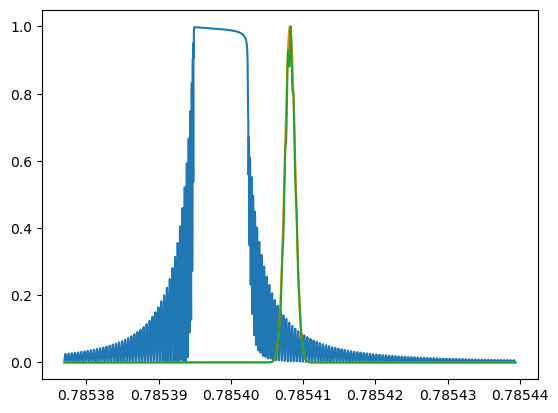

In [51]:
fftfld_transmit = np.einsum('i,ij->ij',R00, fftfld)
spec2 = np.sum(np.abs(fftfld_transmit)**2, axis = (1))
plt.plot(theta, np.abs(R0H)**2)
plt.plot(theta, spec/np.max(spec))
plt.plot(theta, spec2/np.max(spec2))

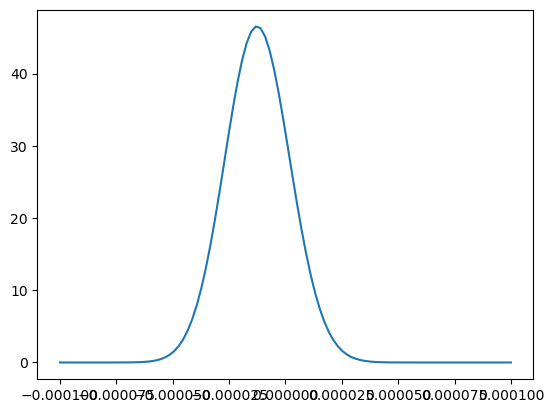

In [52]:
fld_transmit = np.fft.ifft2(np.fft.ifftshift(fftfld_transmit), axes = (0,1))
fld_transmit = fld_transmit[npadx:-npadx]
#fld_transmit = fld_transmit[npadx:-npadx, :]
plt.plot(x, np.sum(np.abs(fld_transmit)**2, axis = (1)))

In [229]:
x0 = 0
y0 =0e-6
r = 40e-6
fld_transmit[(xmesh-x0)**2 + (ymesh-y0)**2 > r**2]=0

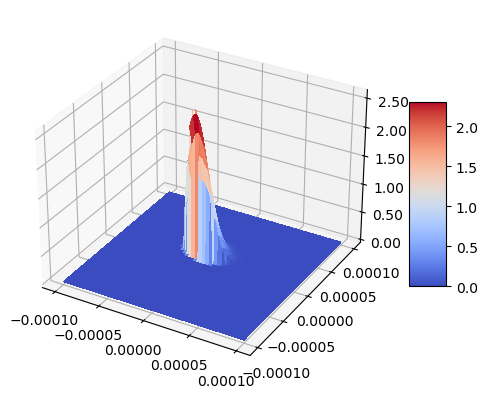

In [230]:
plot_surface(x, y, np.abs(fld_transmit)**2)

In [218]:
np.sqrt(1224)

34.9857113690718

In [192]:
fld_transmit2.shape

(100, 100)

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (1000, 1000) and arg 2 with shape (100, 100).

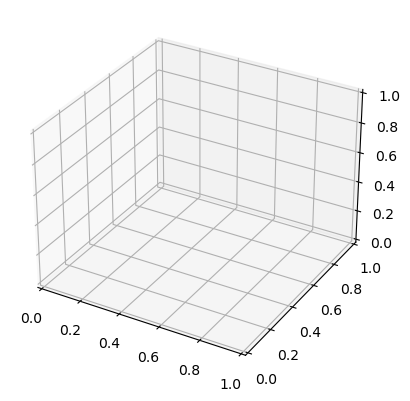

In [193]:
plot_surface(x, y, np.abs(fld_transmit2)**2)

In [89]:
del range

In [181]:
def get_diode_response(tdecay, skew_num, noise_level, intensity):
    x = np.linspace(-10,10,1000)
    y = skewnorm.pdf(x, skew_num)
    y /= np.max(y)
    y *= intensity
    y += np.random.normal(0,noise_level*intensity,len(x))
    x  = (x - np.min(x))/np.max(x)
    x *= tdecay
    
    return x, y

    
     

In [182]:
x, y =get_diode_response(tdecay = 10e-9, skew_num = 8.0, noise_level = 0.05, intensity = 10)

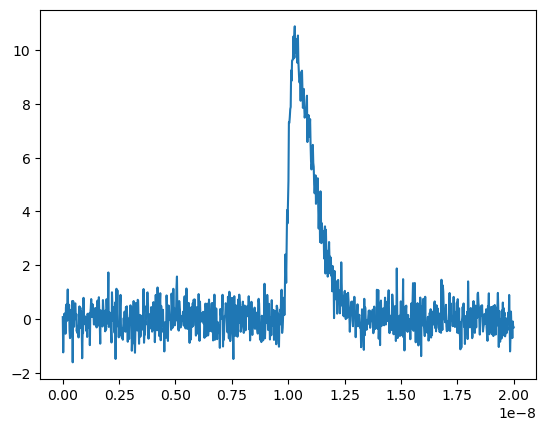

In [183]:
plt.plot( x, y)

In [32]:
from scipy.stats import skewnorm

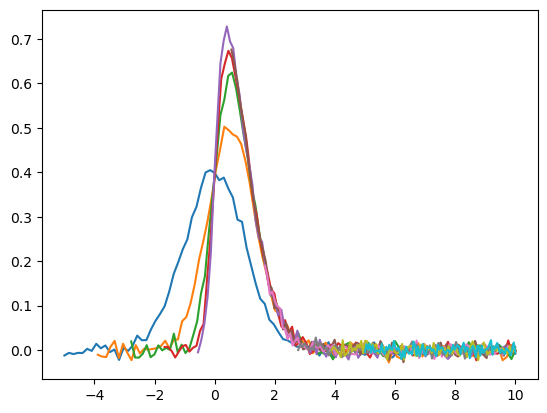

In [53]:
noise_level = 0.01
for a in np.linspace(0, 10, 10):
    x = np.linspace(-5+a,10,100)
    y = skewnorm.pdf(x, a)
    noise  = np.random.normal(0,noise_level,len(x))
    plt.plot(x, y + noise)

In [1]:
from diode_simulator import Diode
from tools import plot_surface
import numpy as np
import matplotlib.pyplot as plt

In [21]:
input_file = '../input/input.yaml'
D = Diode(input_file = input_file)

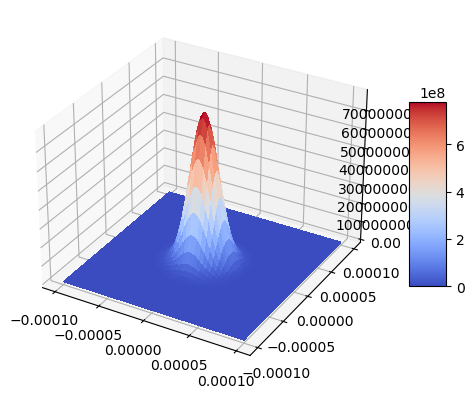

In [3]:
x = D.x
y = D.y
field = D.field

plot_surface(x, y, np.abs(field)**2)

In [4]:
np.sum(np.abs(D.field) ** 2) * D.dx * D.dy

1.0

In [5]:
fftfld = D.fftfld
thetax = D.theta_x
spec = np.sum(np.abs(fftfld)**2, axis = 1)
R0H, R00 = D.get_Bragg_response(d_theta = 10e-6)

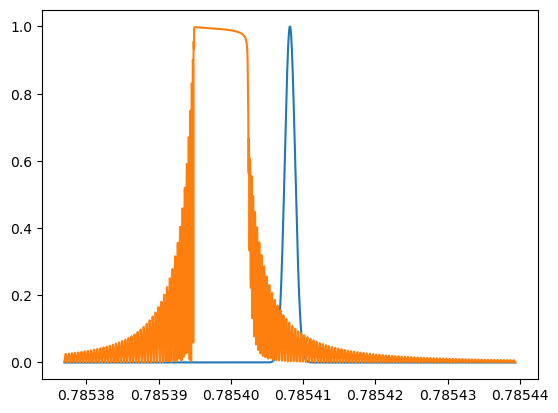

In [6]:
theta = D.theta0 + 10e-6 + D.theta_x
plt.plot(theta, spec/np.max(spec))
plt.plot(theta, np.abs(R0H)**2)

In [7]:
fftfld_transmit = D.forward_diffraction(10e-6)

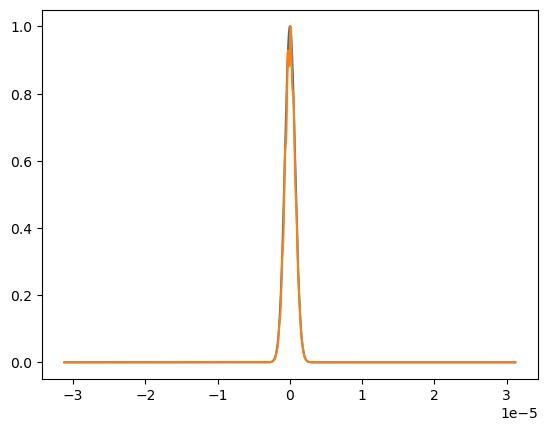

In [8]:
spec2 = np.sum(np.abs(fftfld_transmit)**2, axis = 1)
plt.plot(thetax, spec/np.max(spec))
plt.plot(thetax, spec2/np.max(spec2))


In [9]:
fftfld_transmit_drift = D.drift(fftfld_transmit)

In [10]:
x, y =D.get_diode_response(10)

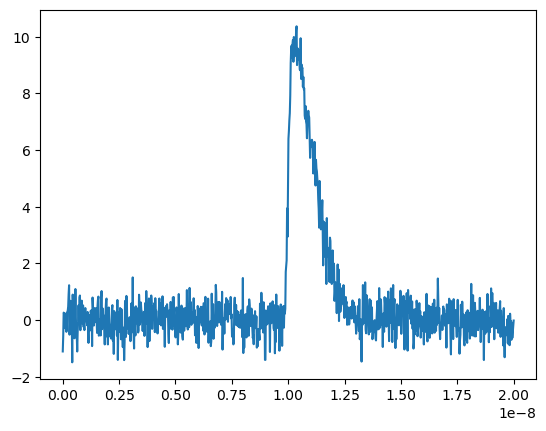

In [11]:
plt.plot(x, y)

In [12]:
np.sum(np.abs(D.field)**2)*D.dx*D.dy

1.0

In [13]:
fld_transmit = np.fft.ifft2(np.fft.ifftshift(fftfld_transmit_drift), axes = (0,1))

In [14]:
fld_transmit = fld_transmit[D.npadx:-D.npadx]
intensity = np.sum(np.abs(fld_transmit)**2)*D.dx*D.dy

In [15]:
intensity

0.673718243231969

In [16]:
x0 = D.diode_position['x']
y0 = D.diode_position['y']
r = D.diode_position['radius']

xmesh, ymesh = np.meshgrid(D.x, D.y, indexing='ij')
fld_transmit[(xmesh - x0) ** 2 + (ymesh - y0) ** 2 > r ** 2] = 0

intensity = np.sum(np.abs(fld_transmit)**2)*D.dx*D.dy
print(intensity)

0.6737168640069242


In [17]:
intensity, time, signal = D.get_diode_signal(10.0e-6)

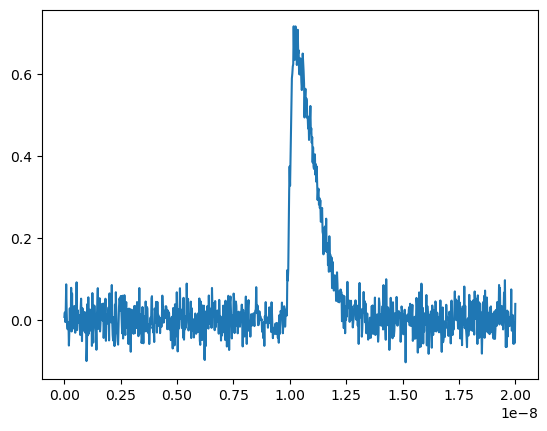

In [18]:
plt.plot(time, signal)

In [19]:
intensity_record, time_record, signal_record = D.scan_theta(np.linspace(-100e-6, 100e-6, 100))

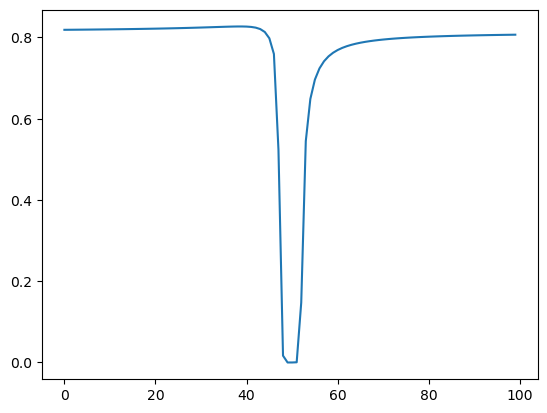

In [20]:
plt.plot(intensity_record)